In [1]:
import numpy as np

import ngsolve 
from ngsolve.webgui import Draw
import netgen.geom2d

### The complex Ginzburg-Landau model on a different mesh in ngsolve

There are various forms of the complex Ginzburg-Landau equation for a field $A \in \mathbb{C}$.

From Cross' book
$$\partial_t A = A + (1 + i c_1) \nabla^2 A - (1-ic_3) |A|^2 A$$

From https://codeinthehole.com/tutorial/index.html  (Winterbottom) 
$$\partial_t A = A + (1 + i \alpha) \nabla^2 A - (1+ i\beta) |A|^2 A$$

These two  are the same if you send $\alpha \to c_1$ and
 $\beta \to - c_3$. 

from Chat\'e's and Manneville's 1996  review https://arxiv.org/abs/1608.07519
$$\partial_t A = A + (1 + i b_1) \nabla^2 A - (b_3-i) |A|^2 A$$

The real Ginzburg-Landau equation is setting $c_1, c_3=0$ of the Cross form or $\alpha=\beta=0$ of the Winterbottom form.
$$\partial_t A = A  + \nabla^2A - |A|^2 A$$

To rescale space you can multiply the Laplacian term by a factor.

In these forms the domain typically has size a few hundred so that interesting phenomena is seen. 
It is somewhat tedious to convert between Chate's form and the other two, but an advantage of 
that form is that they have conveniently classified the different behaviors as a function of $b_1, b_3$. 

The PDE  is obeyed in the domain $\Omega$, 
but on the boundary  $\partial \Omega$ we set $\frac{\partial A}{\partial n} = 0 $. 
This is a Neumann boundary condition. 

The weak/variational form of the problem is 
\begin{align}
\int_\Omega \partial_t u\ w\ dx = \int_\Omega D_u (\Delta u) w \ dx + \int_\Omega g(u) \ w \ dx
\end{align}
with function $$g(u) = u-(1 + i\beta)|u|^2 u, \qquad {\rm or} \qquad  
g(u) = u - (b_3 - i ) |u|^2 u$$ depending upon which form of the equation one wants to use. 

The diffusion coefficient $D_u = (1 + i \alpha)$, 
and for all test functions $w \in \hat V$.  
We integrate by parts the terms that contain a Laplacian operator 
\begin{align}
\int_\Omega \partial_t u\ w \ dx =   - D_u  \int_\Omega \nabla u \nabla w \ dx 
+ D_u\int_{\partial \Omega} \nabla u\ w \ ds
+ \int_\Omega g(u) \ w \ dx 
\end{align}
With normal derivative of $u$ equal to zero on the boundary, the  boundary terms in the above
equations can be neglected.
The weak form should be obeyed for all test functions $w \in \hat V$ with $\hat V = H^1(\Omega)$.
Since we lack Dirichlet regions of the boundary, there is no additional condition on $\hat V$. 
 We are following section 2.2.1 of the Fenics book.

We use a discrete subspace for $\hat V$ and assume we have a nice basis for it. 
We write each term as if it were an operator acting on a vector $w$ (aka the test function) in this basis. 

We split each time step into two pieces.  First updating $u,v$ with an implicit Crank-Nicolson step and 
then we take a first order forward Eulerian step to take into account the function $g$. 

The Crank-Nicolson step for  $\partial_t u = F u  $  with $F$ a linear op is the following scheme 
\begin{align}
\partial_t u \sim \frac{u^{n+1} - u^n}{\Delta t} = \frac{1}{2} \left(F u^{n+1} + F u^n\right)
\end{align}
\begin{align}
\left( 1 - \frac{\Delta t F}{2 } \right) u^{n+1} = \left(1 + \frac{\Delta t F}{2 } \right) u^n \end{align}
\begin{align}
u^{n+1} = \left( 1 - \frac{ \Delta tF}{2} \right)^{-1} \left(1 + \frac{\Delta t F}{2 } \right)u^n
\end{align}
Taking into account the reaction equations for a diffusion reaction system 
\begin{align}
u^{n+1} &= \left( 1 - \frac{ \Delta t}{2 }D_u L \right)^{-1} \left(1 + \frac{\Delta t}{2 }D_uL  \right)u^n + 
\Delta t\ g(u^n)
\end{align}
where $L$ is the Laplacian operator. 

Note: we could bring the $u$ term into the linear operator when we use the Crank Nicolson method. 

The 1's are replaced by mass matrices, when using finite element methods. 


In [4]:
# let's make some kind of domain
#https://docu.ngsolve.org/latest/netgen_tutorials/define_2d_geometries.html
geo = netgen.geom2d.SplineGeometry()
fac = 150  # notice we have a large range in our mesh!!!!
p1 = geo.AppendPoint (0,0)
p2 = geo.AppendPoint (0.7*fac,-0.3*fac)
p3 = geo.AppendPoint (1.4*fac,0*fac)
p4 = geo.AppendPoint (0.6*fac,1*fac)

geo.Append (["spline3", p1, p2, p3],bc="bottom")
geo.Append (["line", p3, p4], bc="right")
geo.Append (["line", p4, p1], bc="left")

maxhval = 2. 

#mtemp = geo.GenerateMesh (maxh=maxhval); Draw(mtemp) 
# lets you look at the mesh without making it into a full mesh that is suitable for FEM

In [5]:
mesh = ngsolve.Mesh(geo.GenerateMesh (maxh=maxhval))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [6]:
# the extra nonlinear function: u is the field, b_3 is the free parameter 
def g(uu,b_3):
    return (uu-(b_3 -1j)*np.absolute(uu)*np.absolute(uu)*uu)   # Chate's form 

In [7]:
fes = ngsolve.H1(mesh, order=3, complex=True)  # We need a complex element
u, v = fes.TnT() # trial and test functions!
gfu = ngsolve.GridFunction(fes) # to hold the solution 


In [8]:
# create initial conditions!

# first get min and max of grid 
def get_range(mesh):
    netgen_mesh = mesh.ngmesh
    p1,p2 = netgen_mesh.bounding_box
    #print(p1,p2)
    xxmin = min(p1[0],p2[0])
    xxmax = max(p1[0],p2[0])
    yymin = min(p1[1],p2[1])
    yymax = min(p1[1],p2[1])
    return xxmin,xxmax,yymin,yymax 

 # relevant for generating seeds

# creates initial condition 
# arguments:
#   gfu: field on mesh for loading with initial conditions
#   nseeds: number of 1 seeds, 
#   sig: and a random dispersion for choosing random initial conditions 
# returns: 
#   nothing, gfu is set 
# globals:  
#   xxmin,xxmax,yymin,yymax to constrain random initial positions for seeds 
#   maxhval for setting width of gaussian seeds    
def gen_init(gfu,mesh,nseeds,sig):
    #sig = 1e-3; 
    r  = gfu.vec.CreateVector()  # create a vector, consistent with gfu
    r.SetRandom(); # fill with random complex numbers 
    r = sig*r  # scale by sig
    ccf = 0.0  # will be a coefficient function 
    xxmin,xxmax,yymin,yymax = get_range(mesh) 

    # seed with some 1 values 
    for k in range(nseeds):
        x_p = np.random.uniform(xxmin,xxmax)  # random position
        y_p = np.random.uniform(yymin,yymax)
        r2 = (ngsolve.x - x_p)*(ngsolve.x - x_p) + (ngsolve.y - y_p)*(ngsolve.y - y_p)
        ccf += ngsolve.exp(-0.5*r2/maxhval**2)  # creates a coefficient function 

    gfu.Set(ccf)   # set the seeds into gfu
    gfu.vec.data += r   # add in random complex numbers 
        

gfu = ngsolve.GridFunction(fes) # to hold the solution 
gen_init(gfu,mesh,40,1e-3)  # run it and then show it
Draw(gfu)  # with pull down menu you can choose real or complex parts to plot or the norm

# old stuff 
    #nv = len(gfu.vec.FV().NumPy()[:])
    
    #for k in range(nv):
    #    gfu.vec.FV().NumPy()[k] = 0.0 + 0*1j   # reset 
    #rvec = np.random.uniform(size=nv)*sig + np.random.uniform(size=nv)*sig*1j/2
    #gfu.vec.FV().NumPy()[:] = rvec
    #gfu.vec.FV().NumPy()[:] +=  np.random.uniform(size=nv)*sig*1j/2
    #for k in range(30):
        #j = np.random.randint(nv-1)
        #gfu.vec.FV().NumPy()[j] = 1.0  # some seed values

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

BaseWebGuiScene

In [11]:
# make assembled operators on finite element space 
# arguments: 
#  fes: finite element space
#  alpha, parameter for model
#  dt timestep
# returns invastar, b operators needed for Crank Nicholson update 
def mk_ops(fes,alpha,dt):

    #alpha = 2.  # must be defined here to make the Laplacian op    alpha = c_1 = b_1 of the different forms
    D_u  = (1 + 1.j*alpha)  # complex diffusion coefficient, Chate form 
    #dt = .01    # timestep 

    # Laplacian op
    a = ngsolve.BilinearForm(fes, symmetric=True)  # holds Laplacian operator 
    a += D_u*ngsolve.grad(u)*ngsolve.grad(v)*ngsolve.dx # This is laplacian with a complex diffusion coef 
    a.Assemble()

    # mass operator 
    m = ngsolve.BilinearForm(fes)  # hold mass matrix 
    m += u*v*ngsolve.dx 
    m.Assemble()

    minv = m.mat.Inverse(freedofs=fes.FreeDofs())

    print(f"m.mat.nze = {m.mat.nze}, a1.mat.nze={a.mat.nze}") # check that they are the same
    # these are the number of nonzero elements in the sparse matrices

    # B = M - 0.5*L*dt , needed for Crank Nicholson update L = Laplacian times diffusion coeff, M = mass matrix
    b_op = m.mat.CreateMatrix()
    b_op.AsVector().data     = m.mat.AsVector() - 0.5*dt * a.mat.AsVector()
    print(f"b_op.nze = {b_op.nze}")

    # A* = M + 0.5 * L * dt   needed for Crank Nicholson update 
    astar = m.mat.CreateMatrix() # create a matrix in the form of m
    astar.AsVector().data = m.mat.AsVector() + 0.5*dt * a.mat.AsVector()
    invastar = astar.Inverse(freedofs=fes.FreeDofs())
    print(f"astar.nze={astar.nze}")

    return invastar, b_op, minv 


# the extra nonlinear function: u is the field, b_3 is the free parameter 
#def g(u,b_3):
#return (u-(b_3 -1j)*np.absolute(u)*np.absolute(u)*u)   # Chate's form 

# create an operator for the nonlinear function  
def mkgfun(fes,b_3):
    gfun = ngsolve.BilinearForm(fes,nonassemble=True)   # don't assemble so nonlinear part can be updated!
    gfun += u*v*ngsolve.dx 
    gfun += -1*(b_3 - 1.0j)*ngsolve.InnerProduct(ngsolve.Conj(u),u)*u*v*ngsolve.dx  # Chate's form 
    return gfun


In [18]:
# for running the integration
# arguments:
#  gfu: grid function field output on finite element space 
#  scene: for drawing updates   output of Draw ngsolve.webgui
#  invastar, b,minv :      # matrix operators on the finite element system 
#  nsamples:  number of outputs to store in the multidimensional data set 
#  b_3: parameter for the complex ginzburg landau model (chate form)
#  dt:        timestep  which was also used in the matrix operators invastar and b 
# returns 
#  gfut:   a multidimensional set of grid functions on finite element system that holds time stepped results
#           at different times 
#  globals: 
#   fes: finite element space , u, v TnTs
 # nojoy, this does not work when True
def TimeStepping_CN(gfu,scene, invastar, b_op, minv,  b_3, dt, initial_cond = None, t0 = 0, tend = 15, 
                 nsamples = 50,gfun_op = True):
    if initial_cond:
        gfu.Set(initial_cond)   # set initial condition, otherwise don't touch the initial fields 
        # as the initial condition could be set already in gfu.vec.data
    cnt = 0; time = t0
    sample_int = int(np.floor(tend / dt / nsamples)+1)  # nsamples is probably the number of outputs we want
    
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)  # creates gfut
    gfut.AddMultiDimComponent(gfu.vec)  #  I think this makes it so we can store a series of solutions 

    if (gfun_op==True):
        gfun = mkgfun(fes,b_3)
        
        # trying yet another approach
        #gfun = ngsolve.BilinearForm(fes,nonassemble=True) 
        #gfun += u*v*ngsolve.dx 
        #gfu_old = gfu
        #gfun += -1*(b_3 - 1.0j)*ngsolve.InnerProduct(ngsolve.Conj(gfu_old),gfu_old)*u*v*ngsolve.dx   # infinity!
        #gfun += -1*(b_3 - 1.0j)*ngsolve.Conj(gfu_old)*gfu_old*u*v*ngsolve.dx  # did not give zero but was
        # not a good solution either!

    while (time < tend - 0.5 * dt):  # integrate until time is about equal to tend 

        if (gfun_op==True):  # compute non-linear part, 
            #gfu_old = gfu
            gfun.Assemble()  # does not work!!!
            #rrres = gfu.vec.CreateVector()
            #gfun.Apply(gfu.vec, rrres)
            #gfun.AssembleLinearization(gfu.vec) # ?   did not work 
        
        res =  b_op * gfu.vec   # you can just multiply b onto gfu.vec (it is a matrix multiply!) # if b is just a matrix
        # res is defined here and is now a vector on the finite element system 
        gfu.vec.data = invastar * res  # replacing solution here for Crank Nicholson update  
        # note you can just multiply invastar onto res  (this is a matrix multiply!)

        # operator split add in non-linear part 
        if (gfun_op==True):
            res = gfun.mat*gfu.vec
            gfu.vec.data += dt*minv*res    # does not work 
        else:
            # by hand does work I think 
            upass = gfu.vec.FV().NumPy()[:]  # get the field 
            gfunv  = g(upass,b_3) # compute the nonlinear term 
            gfu.vec.FV().NumPy()[:] += dt*gfunv # add in non-linear function directly 
            
        print("\r",time,end="")
        if (cnt % sample_int == 0):
            #gfut.AddMultiDimComponent(gfu.vec)
            scene.Redraw()
        cnt += 1; time += dt
    return gfut

In [20]:
alpha = 2. 
dt = 0.02
invastar, b_op, minv  = mk_ops(fes,alpha,dt)

m.mat.nze = 821269, a1.mat.nze=821269
b_op.nze = 821269
astar.nze=821269


In [21]:

gfu = ngsolve.GridFunction(fes) # remake the field to hold the solution 
gen_init(gfu,mesh,60,1e-1)  # generate initial conditions nseeds and random components
scene = Draw(gfu,settings = {  "Colormap" : { "ncolors" : 20 } })  
# with pull down menu you can choose real or complex parts to plot or the norm

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

In [23]:
b_3 = 1.3 # choose a nice pattern ?
gfut_CN = TimeStepping_CN(gfu,scene,invastar, b_op,minv,b_3, dt, t0=0,tend=15)

craete bilinearformapplication
 14.9799999999997715

In [107]:
gfut_CN = TimeStepping_CN(gfu,scene,invastar, b_op,minv,b_3, dt, t0=15,tend=25)

craete bilinearformapplication
 19.679999999999902

KeyboardInterrupt: 

In [85]:
gfut_CN = TimeStepping_CN(gfu,scene,invastar, b,minv,b_3, dt, t0=25,tend=30)

 29.979999999999894

In [ ]:
# seems to have worked.  It would be nice to show phase as well as norm, webgui is not helpful on this respect

In [67]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib inline

# get node points and triangles from a 2d ngsolve-netgen triangular mesh
def pts_tri(mesh):
    # find the x,y coordinates of the mesh 
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0 # store nodes 
    for v in mesh.vertices:
        #print(v,v.point)
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1
    # get a list of triangles in the mesh
    triangles = np.zeros((mesh.ne,3), dtype =int)  # number of elements
    k=0  # store triangles 
    for el in mesh.Elements():
        triangles[k,:] = np.array([el.vertices[0].nr, el.vertices[1].nr, el.vertices[2].nr], dtype = int)
        k += 1
    return xv,yv,triangles


# let's see if we can write our own routine to display amplitude and phase
# mesh need not be that associated with gfu as we use triangular interpolation 
# if you are running this over and over again (like to make pngs)
# then to make this more efficient you need to find the mesh points and triangles beforehand 
# in the above separate routine 
def disp(mesh,gfu,t,xv,yv,triangles):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=150)
    plt.subplots_adjust(left=0.09,right=0.95,bottom=0.01,top=0.99)

    #xv,yv,triangles = pts_tri(mesh) # get coordinates and triangles from the mesh now global 
    
    # get the field values at all the vertices of the mesh
    # gfu does interpolation, gfu need not be on the same mesh as the one passed here 
    uvals = np.zeros(mesh.nv)
    vvals = np.zeros(mesh.nv)
    for k in range(mesh.nv):
        uvals[k] = np.abs(gfu(mesh(xv[k],yv[k])))
        vvals[k] = np.angle(gfu(mesh(xv[k],yv[k])))

    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')

    ax0.tripcolor(xv, yv, uvals,  triangles=triangles)  # show field on triangles 
    ax1.tripcolor(xv, yv, vvals,  triangles=triangles)
    
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  
    fig.colorbar(field0,shrink=0.7)  # colorbar!
    fig.colorbar(field1,shrink=0.7)
    title = ax0.set_title(f'mag,    $t$ = {t:.3f}')  # time stamp
    title = ax1.set_title(f'angle')
    plt.show()
    return fig,axarr
    

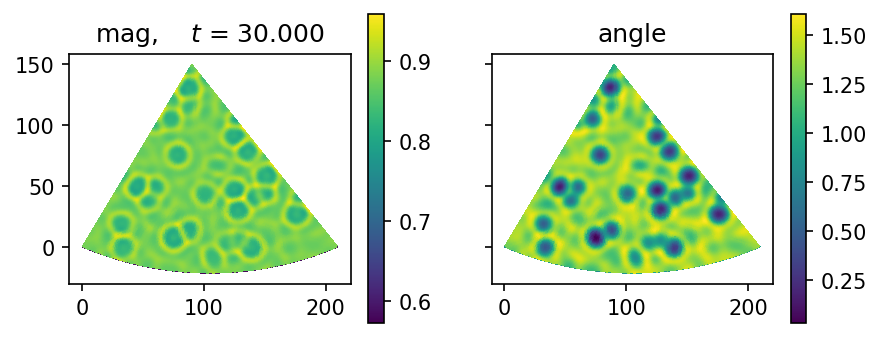

(<Figure size 900x450 with 4 Axes>,
 array([<Axes: title={'center': 'mag,    $t$ = 30.000'}>,
        <Axes: title={'center': 'angle'}>], dtype=object))

In [108]:
# we subdivide the mesh for display  
mesh2 = ngsolve.Mesh(geo.GenerateMesh (maxh=maxhval/2))
xv,yv,triangles = pts_tri(mesh2) # get coordinates and triangles from the mesh

disp(mesh2,gfu,30,xv,yv,triangles)  # worked but is not smooth and boundary does not look great

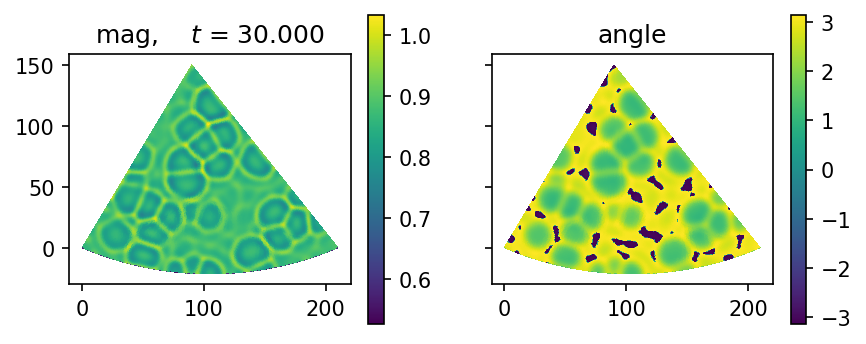

(<Figure size 900x450 with 4 Axes>,
 array([<Axes: title={'center': 'mag,    $t$ = 30.000'}>,
        <Axes: title={'center': 'angle'}>], dtype=object))

In [86]:
# we subdivide the mesh for display  
mesh2 = ngsolve.Mesh(geo.GenerateMesh (maxh=maxhval/2))
xv,yv,triangles = pts_tri(mesh2) # get coordinates and triangles from the mesh

disp(mesh2,gfu,30,xv,yv,triangles)  # worked but is not smooth and boundary does not look great

In [33]:
alpha_b = 0. 
dt_b = 0.02
invastar_b, b_b, minv_b  = mk_ops(fes,alpha_b,dt_b)

m.mat.nze = 3287677, a1.mat.nze=3287677
b.nze = 3287677
astar.nze=3287677


In [35]:
b_3_b = 0.56 # choose a nice pattern ?
gfu_b = ngsolve.GridFunction(fes) # remake the field to hold the solution 
gen_init(gfu_b,0,1e-1)
scene_b = Draw(gfu_b, settings = {  "Colormap" : { "ncolors" : 20 } })  
# with pull down menu you can choose real or complex parts to plot or the norm
gfut_CN_b = TimeStepping_CN(gfu_b, scene_b, invastar_b, b_b,b_3_b, dt_b, t0=0,tend=30)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}, …

 29.9799999999994525

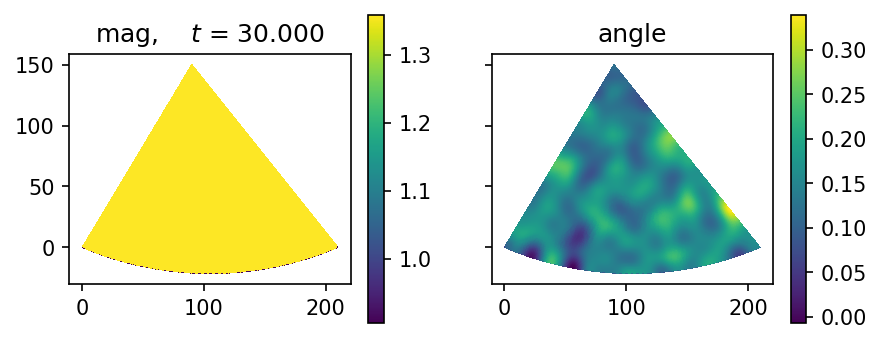

(<Figure size 900x450 with 4 Axes>,
 array([<Axes: title={'center': 'mag,    $t$ = 30.000'}>,
        <Axes: title={'center': 'angle'}>], dtype=object))

In [36]:
#we  subdivide the mesh for display  
#mesh2 = ngsolve.Mesh(geo.GenerateMesh (maxh=maxhval/2))
#xv,yv,triangles = pts_tri(mesh2) # get coordinates and triangles from the mesh

disp(mesh2,gfu_b,30,xv,yv,triangles)  # failed to give any structure!!!!